# ICA on Peak Patch Fields

In [1]:
"""
For path manipulations and module loading
"""
import sys

import importlib
from importlib.util import spec_from_loader, module_from_spec
from importlib.machinery import SourceFileLoader 
from pathlib import Path

import numpy as np
import numpy.random as nprandom
from numpy.random import seed as npseed
from numpy.random import rand as nprand
from numpy.random import randint as nprandint
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

"""
Independent Component Analysis

sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
cube for kurtosis and logcosh for negentropy approximation.
"""
from sklearn.decomposition import FastICA

custom_seed = 379427

## Import parameters

In [2]:
"""

Get path to parameters' file (named 'param.params' in pkpatch)

"""
#########################################################################
#### In final implementation, will have to take path
#### to ppatch runs as input 
#########################################################################

#########################################################################
## Potentially useful code:
#########################################################################
# ppatchruns_dir = os.path.join( script_dir, '..', 'alpha', 'beta' ) # Joins different paths together
# Path("path/to/file.txt").touch() # Creates new empty file.txt (can create other files similarly)
#########################################################################


# Get path to current file's dir
current_path = Path().absolute()

# Get path to current file's parent dir
# parent_path = current_path.parent

# Path to relevant realization
realization_path = current_path/'peak-patch-runs/n1024bigR/z2/fnl1e6/'

# Path to params file
param_file_path = realization_path/'param/param.params'

# Path to dir of relevant field realizations
fields_path = realization_path/'fields'



#########################################################################
## Append params dir path (to sys path???);
## example: need to import module.py present in '/path/to/python/module/not/in/syspath'
##
## This is ultimately not needed given the module-loading code below,
## but keeping it here if needed at some point.
#########################################################################
# sys.path.append(param_dir_path)
#########################################################################



"""
This piece of code loads the parameters file, param.params. Needed to do it this way because of multiple subdirectories in the tree and the period/dot in the name "param.params".
Would have had to create __init__.py files in each subdir otherwise.

Got it from: 
https://csatlas.com/python-import-file-module/#import_any_file_including_non_py_file_extension_python_3_4_and_up
"""
loader = SourceFileLoader( 'param.params' , str(param_file_path))
spec = spec_from_loader( 'param.params', loader )
param = module_from_spec( spec )
loader.exec_module( param )
# Save the module "param" with its full name containing the most imp. params.
# This allows importing "param" directly with the full name.
# The full name is "SideLengthInMpc_SideLengthOfArray_BufferThickness_"
sys.modules['17Mpc_n1024_nb64_nt1.params'] = param





"""
Import relevant parameters needed.

Parameters:
    boxsize     : Side length of the cubic simulation volume (Mpc/h)
    nmesh       : Side length of field array (pixels/array units)
    nbuff       : Buffer thickness (pixels/array units)

*Note on Mpc/h:
An indeterminate unit of distance between 4/3 Mpc and 2 Mpc. The h is a parameter in the closed interval [0.5, 0.75] and reflects an uncertainty in the Hubble constant. For example, in a universe where the Hubble constant is 70km/Mpc/s, h is 0.7. Similarly, a Hubble constant of 50km/Mpc/s would lead to a value for h of 0.5.*
"""
# Side length of the cubic simulation volume
l_mpc = param.boxsize # Mpc/h
# Side length of field arrays
l_array = param.nmesh
# Buffer thickness
l_buff = param.nbuff
# Side length of field array after trimming buffers
l_trim = l_array - l_buff * 2


### This is for a which realization of initial fields? ###

print('Side length (Mpc/h): ', l_mpc, 
        '\nSide length (array units): ', l_array, '\nBuffer thickness (array units): ', l_buff,
        '\nSide length after trimming buffers: ', l_trim)

Side length (Mpc/h):  17.92 
Side length (array units):  1024 
Buffer thickness (array units):  64 
Side length after trimming buffers:  896


## Import PkPatch fields as numpy arrays

### Import Delta fields

In [3]:
"""
Import Gaussian component of Delta field
"""
# Gaussian delta field
delta_g_file = fields_path/'Fvec_17Mpc_n1024_nb64_nt1'
in_delta_g   = open(delta_g_file, 'rb')
# Read in delta_g, reshape it into an nxnxn, and then trim off buffers
delta_g = np.fromfile(in_delta_g,dtype=np.float32,count=-1) 
delta_g = np.reshape(delta_g, (l_array,l_array,l_array), order='F')
delta_g = delta_g[l_buff:-l_buff,l_buff:-l_buff,l_buff:-l_buff]

"""
Import total Delta field (G + nonG)
"""
# Total non-Gaussian delta field
delta_file = fields_path/'Fvec_fNL_17Mpc_n1024_nb64_nt1'
in_delta   = open(delta_file, 'rb')
# Read in delta, reshape it into an nxnxn, and then trim off the buffers
delta = np.fromfile(in_delta,dtype=np.float32,count=-1)
delta = np.reshape(delta, (l_array,l_array,l_array), order='F')
delta = delta[l_buff:-l_buff,l_buff:-l_buff,l_buff:-l_buff]

"""
Import nonG component of Delta (delta - delta_g = delta_ng)
"""
# nonG component of Delta
delta_ng = delta - delta_g 


### Import Zeta fields

In [4]:
"""
Import Gaussian component of Zeta field
"""
# Gaussian zeta field
zeta_g_file = fields_path/'zetag_17Mpc_n1024_nb64_nt1'
in_zeta_g   = open(zeta_g_file, 'rb')
# Read in zeta_g, reshape it into an nxnxn, and then trim off buffers
zeta_g = np.fromfile(in_zeta_g,dtype=np.float32,count=-1)
zeta_g = np.reshape(zeta_g, (l_array,l_array,l_array), order='F')
zeta_g = zeta_g[l_buff:-l_buff,l_buff:-l_buff,l_buff:-l_buff]

"""
Import total Zeta field (G + nonG)
"""
# non-Gaussian zeta field
zeta_file = fields_path/'zetang_17Mpc_n1024_nb64_nt1'
in_zeta   = open(zeta_file, 'rb')
# Read in zeta, reshape it into an nxnxn, and then trim off the buffers
zeta = np.fromfile(in_zeta,dtype=np.float32,count=-1)
zeta = np.reshape(zeta, (l_array,l_array,l_array), order='F')
zeta = zeta[l_buff:-l_buff,l_buff:-l_buff,l_buff:-l_buff]

"""
Import nonG component of Zeta (zeta - zeta_g = zeta_ng)
"""
# nonG component of Zeta
zeta_ng = zeta - zeta_g 

In [6]:
#
# Extracting nonG delta in two halves
#

# sideN = delta.shape[0]
# sideNh = int(sideN/2)
# delta_ng = np.empty_like(delta)
# delta_ng[0:sideNh,0:sideNh,0:sideNh] = delta[0:sideNh,0:sideNh,0:sideNh] - delta_g[0:sideNh,0:sideNh,0:sideNh]
# delta_ng[sideNh:sideN, sideNh:sideN, sideNh:sideN] = delta[sideNh:sideN, sideNh:sideN, sideNh:sideN] - delta_g[sideNh:sideN, sideNh:sideN, sideNh:sideN]
# print(delta_ng[0,0,0])

### Initialize a meshgrid

In [7]:
# Defines X,Y,Z as meshgrid
edges = np.linspace( -l_mpc/2 , l_mpc/2 , l_array+1 )
X,Y,Z = np.meshgrid(edges,edges,edges,indexing='ij')


"""
You now have zeta_g, delta_g, and delta, which are three n-by-n-by-n NumPy arrays representing a gaussian zeta field, a gaussian density field (specifically rho bar times delta, that we talked about today) and a non-gaussian delta field. 
"""

'\nYou now have zeta_g, delta_g, and delta, which are three n-by-n-by-n NumPy arrays representing a gaussian zeta field, a gaussian density field (specifically rho bar times delta, that we talked about today) and a non-gaussian delta field. \n'

### Check random entries from each of the extracted fields

In [6]:
delta_g.shape

(896, 896, 896)

In [5]:
# Random coordinates
x, y, z = nprandint(0, l_trim, 3)

print('Delta Gauss-comp ({}, {}, {}):      '.format(x, y, z), delta_g[x,y,z])
print('Delta nonG-comp ({}, {}, {}):        '.format(x, y, z), delta_ng[x,y,z])
print('Delta total ({}, {}, {}):            '.format(x, y, z), delta[x,y,z])

print('\nZeta Gauss-comp ({}, {}, {}):       '.format(x, y, z), zeta_g[x,y,z])
print('Zeta nonG-comp ({}, {}, {}):         '.format(x, y, z), zeta_ng[x,y,z])
print('Zeta total ({}, {}, {}):             '.format(x, y, z), zeta[x,y,z])

Delta Gauss-comp (25, 69, 791):       -12.152022
Delta nonG-comp (25, 69, 791):         -60912.574
Delta total (25, 69, 791):             -60924.727

Zeta Gauss-comp (25, 69, 791):        -5.89509e-11
Zeta nonG-comp (25, 69, 791):          8.938683e-14
Zeta total (25, 69, 791):              -5.886151e-11


## Extract 1D strips from the 3D fields

In [53]:
def gen_coords_1d_slice(
        seed=None, is_rand_axes=True, side_length=l_trim):
    """
    Generate random indices to take 1D slice from 3D field.

    Args:
        seed (int): Reseed the MT19937 BitGenerator.
        is_rand_axes (bool): Whether to randomize axes or not. Defaults to True.
        side_length (int): Side length of the box after trimming off the buffers.
    
    Returns:
        coords (tuple): List of indices to slice 3D field-array with.
    """
    # Initialize seed for randomization
    # if not given, a random seed will be initialized
    npseed(seed)

    # TWO random coordinates, and a SINGLE, 1D, full slice of the field
    x, y, z = tuple(nprandint(0, side_length, 2))+(range(0, side_length),)
    coords = [x, y, z]

    if is_rand_axes:
        # Shuffle the axes to truly pick out a random 1D slice
        nprandom.shuffle(coords)

    return tuple(coords)


def strip_1d(fields_3d, idx: tuple):    
    """
    Extract 1D strips from the 3D fields.

    Args:
        field_3d (list): 3D fields from which to extract a 1D strip.
        idx (tuple): List of indices to slice 3D field-array with.
    
    Returns:
        fields_1d (): 1D strips corresponding to list of 3D fields in 'field_3d'.
    """

    fields_1d = [i[idx] for i in fields_3d]

    return fields_1d

In [50]:
idx = gen_coords_1d_slice(seed=custom_seed)

fields_3d = [delta_g, delta_ng, delta, zeta_g, zeta_ng, zeta]
dg_1d, dng_1d, d_1d, zg_1d, zng_1d, z_1d = strip_1d(fields_3d, idx)

Indices to pick out 1D slice with:  (659, range(0, 896), 128)


In [47]:
scaling = 1000000

delta_g_1d = delta_g[idx] # 1d Delta field - Gaussian
delta_1d = delta[idx] # 1d Delta field - Total
delta_ng_1d = delta_ng[idx] # 1d Delta field - nonG

zeta_g_1d = zeta_g[idx]*scaling # 1d Zeta field - Gaussian
zeta_1d = zeta[idx]*scaling # 1d Zeta field - Total
zeta_ng_1d = zeta_ng[idx]*scaling # 1d Zeta field - nonG

19.898294 62331.754


### Plot 1D field-strips

#### Delta fields

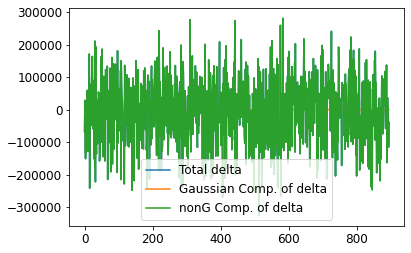

In [16]:
plt.plot(delta_1d, label='Total delta')
plt.plot(delta_g_1d, label='Gaussian Comp. of delta')
plt.plot(delta_ng_1d, label='nonG Comp. of delta')

plt.legend()

#### Zeta fields

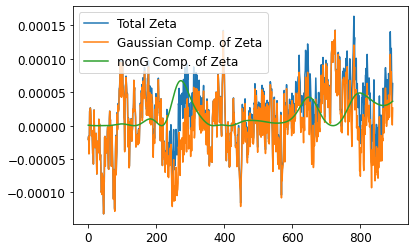

In [17]:

plt.plot(zeta_1d, label='Total Zeta')
plt.plot(zeta_g_1d, label='Gaussian Comp. of Zeta')
plt.plot(zeta_ng_1d, label='nonG Comp. of Zeta')

# plt.ylim([-1, 1])
plt.legend()

## <u>Apply ICA to 1D strips from the 3D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [ ]:
"""
source_noise    :   grf generated using gaussianfield [in Notebook Setup above]
source_nonG     :   returns n columns corresponding to n gaussian peaks that are shifted by xPeak/xc relative to 0 (and scaled by the size of the field)
source_comps    :   array of source component arrays
num_comps       :   num of different source signals/components, i.e. GRF & no. of peaks
num_samples     :   num of observations (has to be >= num_comps)
mix_matrix      :   mixing matrix generated randomly with entries over [0.5, 1)
mix_signal_pre  :   resulting mixed/observed signals (not prewhitened)
"""

source_noise = zeta_g_1d # Gaussian random noise
source_nonG = zeta_ng_1d

source_comps = np.vstack([source_noise, source_nonG]) 
num_comps = source_comps.shape[0]
num_samples = num_comps

mix_matrix = (1+np.random.random((num_samples, num_comps)))/2.0 
print(mix_matrix.shape)
mix_signal_pre = np.dot(mix_matrix, source_comps) # mixed signals
print(mix_signal_pre.shape)

### Sklearn--Fully determined FastICA separation

#### Apply Sklearn's $\texttt{FastICA}$

In [ ]:
# initialize FastICA with given params
# Logcosh is negentropy.
ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=10000, 
        tol=1e-7, fun='logcosh')

# run FastICA on observed (mixed) signals
sl = ica.fit_transform(mix_signal_pre.T) # run FastICA on observed signals

In [ ]:
# ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=100, tol=1e-4, fun='cube')
# sc = ica.fit_transform(mix_signal_pre.T)

In [ ]:
source_max  = np.abs(source_comps).max()
ica_max     = np.abs(sl).max()
print(source_max)
print(ica_max)
sl          = -sl * ( source_max / ica_max )
ica_max     = np.abs(sl).max()
print(ica_max)

#### Plot the following:
#### (1) Observed signals (random mixtures of source components),
#### (2) Source components,
#### (3) ICA separated signals.

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(10,18))

scomps = np.flip(source_comps, axis=0)
offset = source_max*1.8


# Plotting source components
ax[0].set_title("(a) Source Components")
for i in range(scomps.T.shape[-1]):
    ax[0].plot(scomps.T[:,i] + offset*i)
ax[0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
# ax[0].legend()


# Plotting observed signals (mixtures of source signals)
ax[1].set_title("(b) Observed Mixtures of Source Signals")
for i in range(mix_signal_pre.T.shape[-1]):
    ax[1].plot(mix_signal_pre.T[:,i] + offset*i)
ax[1].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting signals separated by ICA
ax[2].set_title("(c) ICA Separated Signals (Num observed signals = num source signals)")
for i in range(sl.shape[-1]):
    ax[2].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting comparison of source comps and ICA-separated signals
ax[3].set_title("(d) Source Comps vs. ICA-Separated Signals")
for i in range(scomps.T.shape[-1]):
    ax[3].plot(scomps.T[:,i] + offset*i)
for i in range(sl.shape[-1]):
    ax[3].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[3].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


fig.suptitle('$\it{FastICA}$-separation using logcosh.\nField realization: $\it{17Mpc-n1024-nb64-nt1}$\n', fontsize=16)
fig.tight_layout()

### [WIP] Rank-order the extracted signals (by a nonG measure)
e.g. using kurtosis

In [ ]:
# # Rank-order by a nonGaussianity measure (kurtosis for simplicity)
# nt = 100; a = np.empty((nt,s.shape[0],s.shape[1])) 
# for i in range(nt):
#     a[i] = ica.extract_peaks_nn(num_samples=num_samples, num_components=num_comps, noise=noise, aPeak=aPeak, xPeak=xPeak, wPeak=wPeak, ns=size_field)[-1]
# kur = ica.kurtosis(a)

# print(kur.shape)
# fig, a = plt.subplots()
# fig.set_size_inches(15, 15)
# for i in range(kur.shape[-1]):
#     a.plot(kur[:,i]+25.*i)